### By: Fasih Atif
### Task 1

**Import Libraries**

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
import statistics
import geopandas as gpd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import re

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

**Set location to search for in OSM**

In [3]:
place_name = "5th district, Budapest, Hungary"

 **Street network is set to drive_Service. This includes all main roads as well as service roads**

In [4]:
graph = ox.graph_from_place(place_name, network_type = "drive_service")

In [5]:
nodes, edges = ox.graph_to_gdfs(graph)

**Current Projection Settings of the data**

In [6]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**To accurately calculate the centroid we first need a plane area rather than a geodic one**

In [7]:
graph_proj = ox.project_graph(graph)

In [8]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj)

**New projected settings in metres**

In [9]:
# check crs
edges_proj.crs

<Projected CRS: +proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
edges_proj.head()

osmid  oneway  \
u          v          key                                            
26732173   84708496   0                           23681399    True   
           4081238851 0    [24005922, 24042923, 371909283]    True   
84708496   256427099  0                          364403765    True   
4081238851 171507014  0                          646403348    True   
26733991   84700676   0              [17275204, 217483071]   False   

                                                                name  \
u          v          key                                              
26732173   84708496   0                             Arany János utca   
           4081238851 0    [Széchenyi rakpart, Széchenyi István tér]   
84708496   256427099  0                                Akadémia utca   
4081238851 171507014  0                         Széchenyi István tér   
26733991   84700676   0                           József Attila utca   

                               highway   length  \
u          v          key                         
26732173   84708496   0    residential   66.330   
           4081238851 0    residential  171.583   
84708496   256427099  0    residential  103.383   
4081238851 171507014  0    residential    9.196   
26733991   84700676   0       tertiary   50.159   

                                                                    geometry  \
u          v          key                                                      
26732173   84708496   0    LINESTRING (352830.570 5262768.701, 352896.475...   
           4081238851 0    LINESTRING (352830.570 5262768.701, 352843.583...   
84708496   256427099  0    LINESTRING (352896.475 5262777.663, 352882.361...   
4081238851 171507014  0    LINESTRING (352879.739 5262607.468, 352884.828...   
26733991   84700676   0    LINESTRING (353504.748 5262509.129, 353485.386...   

                          lanes maxspeed bridge access service tunnel  
u          v          key                                              
26732173   84708496   0     NaN      NaN    NaN    NaN     NaN    NaN  
           4081238851 0       1       50    NaN    NaN     NaN    NaN  
84708496   256427099  0       1       50    NaN    NaN     NaN    NaN  
4081238851 171507014  0       1       50    NaN    NaN     NaN    NaN  
26733991   84700676   0       5       50    NaN    NaN     NaN    NaN

In [11]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
26732173,5.262769e+06,352830.570041,3,19.045812,47.501693,NaN,POINT (352830.570 5262768.701)
84708496,5.262778e+06,352896.474699,4,19.046683,47.501789,NaN,POINT (352896.475 5262777.663)
4081238851,5.262607e+06,352879.738604,3,19.046518,47.500254,NaN,POINT (352879.739 5262607.468)
26733991,5.262509e+06,353504.748309,4,19.054845,47.499511,traffic_signals,POINT (353504.748 5262509.129)
84700676,5.262479e+06,353465.058877,3,19.054328,47.499229,NaN,POINT (353465.059 5262478.798)


**Create a GeoDataFrame of amenities within the boundaries of District 5 Budapest**

In [12]:
tags = {'amenity':True}
amenities = ox.geometries_from_place(place_name, tags)

In [15]:
warnings.filterwarnings('ignore')

In [16]:
amenities.head()

,unique_id,osmid,element_type,access,amenity,capacity,charge,fee,lit,name,opening_hours,parking,payment:cash,payment:maestro,payment:mastercard,payment:visa,payment:visa_debit,payment:visa_electron,supervised,website,wheelchair,geometry,operator,layer,recycling:glass_bottles,recycling:plastic_bottles,recycling_type,addr:city,addr:housenumber,addr:postcode,addr:street,alt_name,dog,email,facebook,internet_access,note,phone,screen,addr:country,ref:vatin:hu,branch,brand,brand:wikidata,brand:wikipedia,contact:email,contact:facebook,contact:instagram,contact:phone,contact:website,contact:youtube,operator:addr,payment:debit_cards,ref:vatin,source:www.posta.hu:date,ref,created_by,description,drive_through,level,healthcare,name:de,name:en,name:hu,cuisine,wheelchair:description,name:it,atm,air_conditioning,bic,ref:HU:company,source:www.cib.hu:date,outdoor_seating,toilets:wheelchair,short_name,takeaway,currency:AED,currency:AUD,currency:BAM,currency:BGN,currency:BRL,currency:CAD,currency:CHF,currency:CNY,currency:CZK,currency:DKK,currency:EUR,currency:GBP,currency:HRK,currency:HUF,currency:ILS,currency:JPY,currency:MXN,currency:MYR,currency:NOK,currency:NZD,currency:PLN,currency:RON,currency:RSD,currency:RUB,currency:SEK,currency:THB,currency:TRY,currency:UAH,currency:USD,payment:credit_cards,payment:mobile_wallet,payment:paysafecard,internet_access:fee,official_name,ref:om,operator:type,wikidata,wikipedia,entrance,unisex,denomination,religion,smoking,chip_scanner,diet:vegetarian,diet:vegan,lunch,start_date,stop_date,toilets,craft,shop,payment:contactless,payment:mastercard_contactless,payment:mastercard_electronic,delivery,fixme,is_in,url,contact:fax,name:fr,name:ru,name:zh,fax,tourism,dispensing,bicycle_parking,covered,drinking_water,backrest,free_refill,old_name,owncup,owncup:discount,payment:coins,vending,bicycle,ferry,public_transport,lines,ref:bkk,check_date,artist_name,artwork_type,wifi,diet:lactose_free,free_refill_note,internet_access:ssid,addr:housename,source,lgbtq,check_date:opening_hours,organic,payment:szep,name:ar,step_count,description:en,emergency,cocktails,distillery,opening_hours:covid19,currency:GPB,payment:phonecards,payment:bitcoin,check_date:capacity,maxheight,park_ride,barrier,service:bicycle:rental,service:bicycle:retail,female,male,payment:account_cards,payment:electronic_purses,payment:notes,architect,historic,image,wheelchair:description:hu,shelter_type,capacity:disabled,reservation,changing_table:fee,colour,material,seats,collection_times,healthcare:speciality,payment:american_express,payment:cards,contact:twitter,gay,second_hand,recycling:paper,club,amperage,parking:fee,socket:type2,voltage,microbrewery,parking:ticket:zone,authentication:app,authentication:membership_card,authentication:none,manufacturer,model,motorcar,socket:chademo,socket:chademo:output,socket:type2_cable,socket:type2_cable:output,socket:type2_combo,socket:type2_combo:output,source:www.mobiliti.hu:date,url:miserend,training,lunch:buffet:cost,capacity:description,indoor,source:www.budapestbank.hu:date,display,support,visibility,gambling,ref:internal,ref:location,strapline,service:bicycle:chain_tool,service:bicycle:pump,waste,name:he,diet:raw,books:language:eo,name:eo,happy_hours,lunch:menu,lunch:menu:cost,lunch:menu:course:main,lunch:menu:course:soup,bench,addr:floor,door,lunch:menu:price,name:zh_pinyin,comment,source:e-mobi.hu:date,strapline:ru,toilets:access,source:www.magnetbank.hu:date,surface,survey:date,payment:telephone_cards,social_facility,social_facility:for,education,education_profile,nodes,building,building:levels,roof:levels,roof:shape,official_name:de,construction_date,loc_name,heritage,name:el,name:sr,building:colour,building:material,height,name:ca,name:cs,name:es,name:ko,wheelchair:description:de,smoothness,bus,tourist_bus,ways,type,addr:conscriptionnumber
0,node/260230764,260230764,node,yes,parking_entrance,746,250HUF/30min,yes,yes,Liberty Square Parking,24/7,underground,yes,yes,yes,yes,yes,yes,yes,http://www.libertysquare

**Checking the different amenities and their counts in the Geo dataframe**

In [17]:
amenities['amenity'].value_counts()

bench                     262
restaurant                252
waste_basket              244
vending_machine           138
bicycle_parking           136
cafe                      123
fast_food                  83
pub                        51
atm                        45
bank                       41
bureau_de_change           39
fountain                   38
parking                    32
bar                        31
telephone                  24
parking_entrance           18
post_box                   16
place_of_worship           15
school                     14
toilets                    13
drinking_water             12
dentist                    11
pharmacy                   10
post_office                 9
ice_cream                   8
doctors                     8
university                  8
library                     7
arts_centre                 6
courthouse                  6
charging_station            6
nightclub                   5
community_centre            5
recycling 

## Collect family-related POIs (primary schools, nursery homes, kinder gardens, and playgrounds) from online sources

**SCHOOLS** \
It includes kindergaten and primary schools

In [18]:
# Filter schools from amenties dataframe
schools = amenities[(amenities['amenity'] == 'kindergarten') | (amenities["amenity"]== 'school')]

In [19]:
# Split the column 'unique_id' to get the node id. node/260230764 ----> 260230764
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

schools['node_id'] = schools['unique_id'].apply(lambda x: find_number(x))

In [20]:
schools.head()

,unique_id,osmid,element_type,access,amenity,capacity,charge,fee,lit,name,opening_hours,parking,payment:cash,payment:maestro,payment:mastercard,payment:visa,payment:visa_debit,payment:visa_electron,supervised,website,wheelchair,geometry,operator,layer,recycling:glass_bottles,recycling:plastic_bottles,recycling_type,addr:city,addr:housenumber,addr:postcode,addr:street,alt_name,dog,email,facebook,internet_access,note,phone,screen,addr:country,ref:vatin:hu,branch,brand,brand:wikidata,brand:wikipedia,contact:email,contact:facebook,contact:instagram,contact:phone,contact:website,contact:youtube,operator:addr,payment:debit_cards,ref:vatin,source:www.posta.hu:date,ref,created_by,description,drive_through,level,healthcare,name:de,name:en,name:hu,cuisine,wheelchair:description,name:it,atm,air_conditioning,bic,ref:HU:company,source:www.cib.hu:date,outdoor_seating,toilets:wheelchair,short_name,takeaway,currency:AED,currency:AUD,currency:BAM,currency:BGN,currency:BRL,currency:CAD,currency:CHF,currency:CNY,currency:CZK,currency:DKK,currency:EUR,currency:GBP,currency:HRK,currency:HUF,currency:ILS,currency:JPY,currency:MXN,currency:MYR,currency:NOK,currency:NZD,currency:PLN,currency:RON,currency:RSD,currency:RUB,currency:SEK,currency:THB,currency:TRY,currency:UAH,currency:USD,payment:credit_cards,payment:mobile_wallet,payment:paysafecard,internet_access:fee,official_name,ref:om,operator:type,wikidata,wikipedia,entrance,unisex,denomination,religion,smoking,chip_scanner,diet:vegetarian,diet:vegan,lunch,start_date,stop_date,toilets,craft,shop,payment:contactless,payment:mastercard_contactless,payment:mastercard_electronic,delivery,fixme,is_in,url,contact:fax,name:fr,name:ru,name:zh,fax,tourism,dispensing,bicycle_parking,covered,drinking_water,backrest,free_refill,old_name,owncup,owncup:discount,payment:coins,vending,bicycle,ferry,public_transport,lines,ref:bkk,check_date,artist_name,artwork_type,wifi,diet:lactose_free,free_refill_note,internet_access:ssid,addr:housename,source,lgbtq,check_date:opening_hours,organic,payment:szep,name:ar,step_count,description:en,emergency,cocktails,distillery,opening_hours:covid19,currency:GPB,payment:phonecards,payment:bitcoin,check_date:capacity,maxheight,park_ride,barrier,service:bicycle:rental,service:bicycle:retail,female,male,payment:account_cards,payment:electronic_purses,payment:notes,architect,historic,image,wheelchair:description:hu,shelter_type,capacity:disabled,reservation,changing_table:fee,colour,material,seats,collection_times,healthcare:speciality,payment:american_express,payment:cards,contact:twitter,gay,second_hand,recycling:paper,club,amperage,parking:fee,socket:type2,voltage,microbrewery,parking:ticket:zone,authentication:app,authentication:membership_card,authentication:none,manufacturer,model,motorcar,socket:chademo,socket:chademo:output,socket:type2_cable,socket:type2_cable:output,socket:type2_combo,socket:type2_combo:output,source:www.mobiliti.hu:date,url:miserend,training,lunch:buffet:cost,capacity:description,indoor,source:www.budapestbank.hu:date,display,support,visibility,gambling,ref:internal,ref:location,strapline,service:bicycle:chain_tool,service:bicycle:pump,waste,name:he,diet:raw,books:language:eo,name:eo,happy_hours,lunch:menu,lunch:menu:cost,lunch:menu:course:main,lunch:menu:course:soup,bench,addr:floor,door,lunch:menu:price,name:zh_pinyin,comment,source:e-mobi.hu:date,strapline:ru,toilets:access,source:www.magnetbank.hu:date,surface,survey:date,payment:telephone_cards,social_facility,social_facility:for,education,education_profile,nodes,building,building:levels,roof:levels,roof:shape,official_name:de,construction_date,loc_name,heritage,name:el,name:sr,building:colour,building:material,height,name:ca,name:cs,name:es,name:ko,wheelchair:description:de,smoothness,bus,tourist_bus,ways,type,addr:conscriptionnumber,node_id
48,node/261440554,261440554,node,NaN,school,NaN,NaN,NaN,NaN,Szent István Általános Iskola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (19.05096 47.50694),Na

In [21]:
# Project the school entities to metres projection
schools.to_crs(edges_proj.crs, inplace = True)

In [22]:
schools.crs

<Projected CRS: +proj=utm +zone=34 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 34N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Some of the entities in the school dataframe are ways or relations. We need to find the centroid of these entities**

In [23]:
schools['centroid'] = schools.apply(lambda x : x['geometry'].centroid if x['element_type'] != 'node' else x['geometry'], axis=1)

In [24]:
# Remove extra columns that are not required or have too many NA values
schools = schools.filter(items=['node_id', 'name','element_type','amenity', 'geometry', 'centroid', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street'])


In [25]:
# Final school dataframe
schools

,node_id,name,element_type,amenity,geometry,centroid,addr:city,addr:housenumber,addr:postcode,addr:street
48,261440554,Szent István Általános Iskola,node,school,POINT (353233.042 5263341.525),POINT (353233.0424880527 5263341.525400361),Budapest,3,1054,Szemere utca
200,1019252186,Belvárosi Tanoda Alapítványi Gimnázium és Szak...,node,school,POINT (353516.322 5261613.189),POINT (353516.3223513303 5261613.188643141),Budapest,19-23,1056,Irányi utca
248,2040618295,Budapesti Piarista Gimnázium,node,school,POINT (353295.199 5261800.896),POINT (353295.1992736906 5261800.895979309),Budapest,1,1052,Piarista utca
688,3279456683,Papnövelde utcai bölcsőde,node,kindergarten,POINT (353623.105 5261559.532),POINT (353623.1047479182 5261559.531604317),Budapest,4-6,1053,Papnövelde utca
1251,5062617922,NaN,node,kindergarten,POINT (353550.487 5261258.351),POINT (353550.4866955306 5261258.350562215),NaN,NaN,NaN,NaN
1407,6439831635,Tesz-Vesz Óvoda,node,kindergarten,POINT (353294.308 5262476.227),POINT (353294.3082781514 5262476.227126786),Budapest,18,1051,József Attila utca
1446,6770679601,Szemere Bertalan Általános Iskola,node,school,POINT (353230.153 5263362.993),POINT (353230.1528805089 5263362.992919378),Budapest,5,1054,Szemere utca
1489,6778119043,Négy Évszak Magánóvoda,node,kindergarten,POINT (353440.198 5263179.605),POINT (353440.198278453 5263179.60505019),Budapest,29,1054,Vadász utca
1633,8016526611,"Budapesti Innovatív Gimnázium, Szakgimnázium é...",node,school,POINT (353290.999 5262801.638),POINT (353290.9993514399 5262801.638239642),Budapest,25,1051,Sas utca
1719,24054275,Xántus János Két Tanítási Nyelvű Gimnázium,way,school,"POLYGON ((353379.384 5263658.991, 353395.280 5...",POINT (353408.0927671446 5263617.915258432),Budapest,18-20,1055,Markó utca


**SOCIAL FACILITIES** \
It includes senior, disabled, mental_health homes and facilities

In [26]:
# Filter social facilities from amenties dataframe
social_facilities = amenities[amenities['amenity'] == 'social_facility']

In [27]:
social_facilities['element_type'].value_counts()

node    3
way     1
Name: element_type, dtype: int64

In [28]:
# Project to metres
social_facilities.to_crs(edges_proj.crs, inplace = True)

In [29]:
# Find centroid values for way entities
social_facilities['centroid'] = social_facilities.apply(lambda x : x['geometry'].centroid if x['element_type'] != 'node' else x['geometry'], axis=1)

In [30]:
# Remove extra columns that are not required or have too many NA values
social_facilities = social_facilities.filter(items=['name','element_type','amenity', 'geometry', 'centroid','addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street'])

In [31]:
# Final social facilities dataframe
social_facilities

,name,element_type,amenity,geometry,centroid,addr:city,addr:housenumber,addr:postcode,addr:street
822,Fehér Gyűrű KHE,node,social_facility,POINT (353036.420 5263990.816),POINT (353036.4203545571 5263990.816138052),Budapest,1,1055,Szent István körút
1009,Belgrád rakparti Idősek Klubja,node,social_facility,POINT (353297.619 5261564.590),POINT (353297.6186971343 5261564.590307252),Budapest,27,1056,Belgrád rakpart
1621,Időskorúak Gondozóháza,node,social_facility,POINT (353097.542 5262546.517),POINT (353097.5417157388 5262546.517020619),NaN,NaN,NaN,NaN
1733,Idősek klubja,way,social_facility,"POLYGON ((353449.446 5263027.518, 353470.489 5...",POINT (353461.277321105 5263004.744153691),Budapest,11-13,1054,Vadász utca


**PLAYGROUNDS**

In [32]:
tags = {'leisure':'playground'} 
playgrounds = ox.geometries_from_place(place_name, tags)

In [33]:
# Split the column 'unique_id' to get the node id. node/260230764 ----> 260230764
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)

playgrounds['node_id'] = playgrounds['unique_id'].apply(lambda x: find_number(x))

C:\Users\abc\anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# project metres
playgrounds.to_crs(edges_proj.crs, inplace = True)

In [35]:
# Find centroids of ways and relation entities
playgrounds['centroid'] = playgrounds.apply(lambda x : x['geometry'].centroid if x['element_type'] != 'node' else x['geometry'], axis=1)

In [36]:
# Remove extra columns that are not required or have too many NA values
playgrounds = playgrounds.filter(items=['node_id','name', 'leisure', 'element_type', 'geometry', 'centroid'])

In [37]:
# Final playgrounds dataframe
playgrounds

,node_id,name,leisure,element_type,geometry,centroid
0,1412802122,NaN,playground,node,POINT (353211.778 5262506.064),POINT (353211.7784495194 5262506.063937325)
1,2705477708,NaN,playground,node,POINT (353647.222 5261356.967),POINT (353647.2224621433 5261356.967090472)
2,4487850194,Honvéd téri játszótér,playground,node,POINT (353206.423 5263687.683),POINT (353206.4230847551 5263687.682963762)
3,105731131,NaN,playground,way,"POLYGON ((353847.528 5261661.964, 353867.528 5...",POINT (353861.0348261432 5261660.493633623)
4,105731163,NaN,playground,way,"POLYGON ((353836.293 5261691.913, 353831.515 5...",POINT (353844.3570713769 5261702.527504251)
5,105731171,NaN,playground,way,"POLYGON ((353868.243 5261712.788, 353873.387 5...",POINT (353876.7804881352 5261693.326754027)
6,264650344,Bástya utcai óvoda játszókertje,playground,way,"POLYGON ((353814.777 5261280.711, 353794.755 5...",POINT (353797.1347747815 5261286.196081174)
7,271221645,NaN,playground,way,"POLYGON ((352895.246 5263773.231, 352889.533 5...",POINT (352913.8230582152 5263752.918900997)
8,310830371,Kis játszótér,playground,way,"POLYGON ((353154.012 5262948.079, 353154.354 5...",POINT (353160.2399954703 5262943.141421031)
9,310830374,NaN,playground,way,"POLYGON ((353225.076 5262956.471, 353225.583 5...",POINT (353231.6829819137 5262952.359090304)


## Calculate Euclidean Distances between POI Categories

**Schools and Playgrounds: Calculate euclidean distance between each entity of school to each entity of playground**

In [51]:
warnings.filterwarnings('ignore')

In [52]:
column_names = ['school','playground','school_coords','playground_coords','euclidean_dist']
distance_df = gpd.GeoDataFrame(columns = column_names)

for index_s ,row_s in schools.iterrows():
    for index_p, row_p in playgrounds.iterrows():
        euc_dist = ox.distance.euclidean_dist_vec(row_s.centroid.y, row_s.centroid.x, row_p.centroid.y, row_p.centroid.x)
        new_row = {'school' : row_s['name'], 'playground':row_p['name'] , 'school_coords': row_s.centroid, 'playground_coords' :row_p.centroid, 'euclidean_dist': euc_dist}
        distance_df = distance_df.append(new_row, ignore_index = True)

In [39]:
distance_df

,school,playground,school_coords,playground_coords,euclidean_dist
0,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353211.7784495194 5262506.063937325),835.732024
1,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353647.2224621433 5261356.967090472),2027.317621
2,Szent István Általános Iskola,Honvéd téri játszótér,POINT (353233.0424880527 5263341.525400361),POINT (353206.4230847551 5263687.682963762),347.179566
3,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353861.0348261432 5261660.493633623),1794.503323
4,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353844.3570713769 5261702.527504251),1749.291177
5,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353876.7804881352 5261693.326754027),1769.451155
6,Szent István Általános Iskola,Bástya utcai óvoda játszókertje,POINT (353233.0424880527 5263341.525400361),POINT (353797.1347747815 5261286.196081174),2131.332616
7,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (352913.8230582152 5263752.918900997),520.716484
8,Szent István Általános Iskola,Kis játszótér,POINT (353233.0424880527 5263341.525400361),POINT (353160.2399954703 5262943.141421031),404.981478
9,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353231.6829819137 5262952.359090304),389.168685


**Average euclidean distance between each school and playground category**

In [54]:
mean_schools_and_plyagrounds = statistics.mean(distance_df['euclidean_dist'])

In [55]:
mean_schools_and_plyagrounds

1060.8006494085696

## Manhattan Distance

In [41]:
from scipy.spatial import distance

In [42]:
manhattan_dist = []

for index_s ,row_s in schools.iterrows():
    for index_p, row_p in playgrounds.iterrows():
        p1 = (row_s.centroid.x, row_s.centroid.y)
        p2 = (row_p.centroid.x, row_p.centroid.y)
        manhat_dist = distance.cityblock(p1,p2)
        manhattan_dist.append(manhat_dist)
        
distance_df['manhattan_dist'] = manhattan_dist

In [43]:
distance_df

,school,playground,school_coords,playground_coords,euclidean_dist,manhattan_dist
0,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353211.7784495194 5262506.063937325),835.732024,856.725502
1,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353647.2224621433 5261356.967090472),2027.317621,2398.738284
2,Szent István Általános Iskola,Honvéd téri játszótér,POINT (353233.0424880527 5263341.525400361),POINT (353206.4230847551 5263687.682963762),347.179566,372.776967
3,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353861.0348261432 5261660.493633623),1794.503323,2309.024105
4,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353844.3570713769 5261702.527504251),1749.291177,2250.312479
5,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353876.7804881352 5261693.326754027),1769.451155,2291.936646
6,Szent István Általános Iskola,Bástya utcai óvoda játszókertje,POINT (353233.0424880527 5263341.525400361),POINT (353797.1347747815 5261286.196081174),2131.332616,2619.421606
7,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (352913.8230582152 5263752.918900997),520.716484,730.612930
8,Szent István Általános Iskola,Kis játszótér,POINT (353233.0424880527 5263341.525400361),POINT (353160.2399954703 5262943.141421031),404.981478,471.186472
9,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353231.6829819137 5262952.359090304),389.168685,390.525816


**Find,measure, and visualize the shortest shortest paths and the longest shortest path (based on the road network) between each pair of POI categories.**

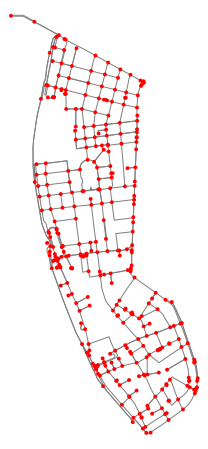

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [56]:
ox.plot_graph(graph_proj, edge_color = "grey", node_color = "red", bgcolor = "white")

In [57]:
shortest_path_node_list = []
shortest_path_dist_list = []

for index_s ,row_s in schools.iterrows():
    for index_p, row_p in playgrounds.iterrows():
        
        orig_xy = (row_s.centroid.y, row_s.centroid.x)

        target_xy = (row_p.centroid.y, row_p .centroid.x)

        orig_node = ox.get_nearest_node(graph_proj, orig_xy)

        target_node = ox.get_nearest_node(graph_proj, target_xy, method='euclidean')

        shortest_path_nodes = ox.shortest_path(graph_proj, orig_node , target_node, weight='length')
        
        shortest_path_node_list.append(shortest_path_nodes)
        
        shortest_path_dist = nx.shortest_path_length(graph_proj, orig_node , target_node, weight='length')
        
        shortest_path_dist_list.append(shortest_path_dist)
        
distance_df['shortest_path_nodes'] = shortest_path_node_list
        
distance_df['shortest_path_dist'] = shortest_path_dist_list
        

In [46]:
distance_df.head()

,school,playground,school_coords,playground_coords,euclidean_dist,manhattan_dist,shortest_path_nodes,shortest_path_dist
0,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353211.7784495194 5262506.063937325),835.732024,856.725502,"[275958444, 244941470, 3264793779, 260098987, ...",2065.923
1,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353647.2224621433 5261356.967090472),2027.317621,2398.738284,"[275958444, 244941470, 3264793779, 260098987, ...",3442.203
2,Szent István Általános Iskola,Honvéd téri játszótér,POINT (353233.0424880527 5263341.525400361),POINT (353206.4230847551 5263687.682963762),347.179566,372.776967,"[275958444, 244941470, 3264793779, 260098987, ...",380.438
3,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353861.0348261432 5261660.493633623),1794.503323,2309.024105,"[275958444, 244941470, 3264793779, 260098987, ...",2909.086
4,Szent István Általános Iskola,NaN,POINT (353233.0424880527 5263341.525400361),POINT (353844.3570713769 5261702.527504251),1749.291177,2250.312479,"[275958444, 244941470, 3264793779, 260098987, ...",2814.579


**Shortest Shortest Path Row**

In [58]:
short_short_path_row = distance_df[distance_df.shortest_path_dist == distance_df.shortest_path_dist.min()]
short_short_path_row

,school,playground,school_coords,playground_coords,euclidean_dist,shortest_path_nodes,shortest_path_dist
50,Papnövelde utcai bölcsőde,NaN,POINT (353623.1047479182 5261559.531604317),POINT (353334.1364791799 5262328.393641818),821.371714,"[78089505, 683890802, 260676612]",77.89


**Longest Shortest Path Row**

In [59]:
long_short_path_row = distance_df[distance_df.shortest_path_dist == distance_df.shortest_path_dist.max()]
long_short_path_row

,school,playground,school_coords,playground_coords,euclidean_dist,shortest_path_nodes,shortest_path_dist
210,Ward Mária Általános Iskola és Gimnázium,Honvéd téri játszótér,POINT (353388.903188662 5261522.715749855),POINT (353206.4230847551 5263687.682963762),2172.644017,"[262767957, 262768232, 1312639754, 714186833, ...",3921.837
220,Ward Mária Általános Iskola és Gimnázium,NaN,POINT (353388.903188662 5261522.715749855),POINT (353208.6316256044 5263687.574843309),2172.351889,"[262767957, 262768232, 1312639754, 714186833, ...",3921.837


### From School to Playground

**Longest Shortest Path** \
From School: Ward Mária Általános Iskola és Gimnázium \
To Playground: Honvéd téri játszótér

**Shortest Shortest Path** \
From School: Papnövelde utcai bölcsőde	 \
To Playground: Nan

C:\Users\abc\anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


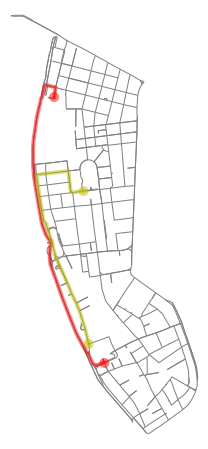

In [49]:
#Longest Shortest Route
origin_point_long = (353388.903188662, 5261522.715749855)
destination_point_long = (353206.4230847551, 5263687.682963762)
origin_node_long = ox.get_nearest_node(graph_proj, origin_point_long)
destination_node_long = ox.get_nearest_node(graph_proj, destination_point_long)
route_long = nx.shortest_path(graph_proj, origin_node_long, destination_node_long, weight='length')

#Shortest Shortest Route
origin_point_short = (353623.1047479182, 5261559.531604317)
destination_point_short = (353334.1364791799, 5262328.393641818)
origin_node_short = ox.get_nearest_node(graph_proj, origin_point_short)
destination_node_short = ox.get_nearest_node(graph_proj, destination_point_short)
route_short = nx.shortest_path(graph_proj, origin_node_short, destination_node_short, weight='length')

# Plot graph
routes = [route_long, route_short]
rc = ["r", "y"]
fig, ax = ox.plot_graph_routes(graph_proj, routes, route_colors=rc, edge_color = "grey", node_color = "grey", bgcolor = "white", node_size = 0)


**Interactive Folium Map for Longest Shortest Path**

In [60]:
# plot the street network with folium
origin_point = (353388.903188662, 5261522.715749855)
destination_point = (353206.4230847551, 5263687.682963762)
origin_node = ox.get_nearest_node(graph_proj, origin_point)
destination_node = ox.get_nearest_node(graph_proj, destination_point)
route = nx.shortest_path(graph_proj, origin_node, destination_node, weight='length')
ox.plot_route_folium(graph, route)